In [70]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, plot_metrics, make_axis_great_again, plot_epochs

In [72]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '29.04_06.05_scaling-up'

human36m_alg_AlgebraicTriangulationNet@05.05.2021-09:18:03 correctly parsed
training on 12, evaluating on 5
found 77 epochs
training loss in [80304.9, 111054.8]
training metrics in [545.5, 68789.2]
eval metrics in [328.1, 872.3]
- plotted metrics [80304.9, 111054.8] in epochs [0, 76]
- plotted metrics [545.5, 68789.2] in epochs [0, 76]
- plotted metrics [328.1, 872.3] in epochs [0, 76]
human36m_alg_AlgebraicTriangulationNet@03.05.2021-10:30:57 correctly parsed
training on 12, evaluating on 5
found 1000 epochs
training loss in [0.1, 36.7]
training metrics in [25.2, 766050.7]
eval metrics in [274.5, 585949.1]
- plotted metrics [0.1, 36.7] in epochs [0, 999]
- plotted metrics [25.2, 766050.7] in epochs [0, 999]
- plotted metrics [274.5, 585949.1] in epochs [0, 999]


Text(0.5, 0.98, 'cam2cam estimation (12 / 5 train / validation images), optimizing just last 3 layers of BB, lr BB=1e-6')

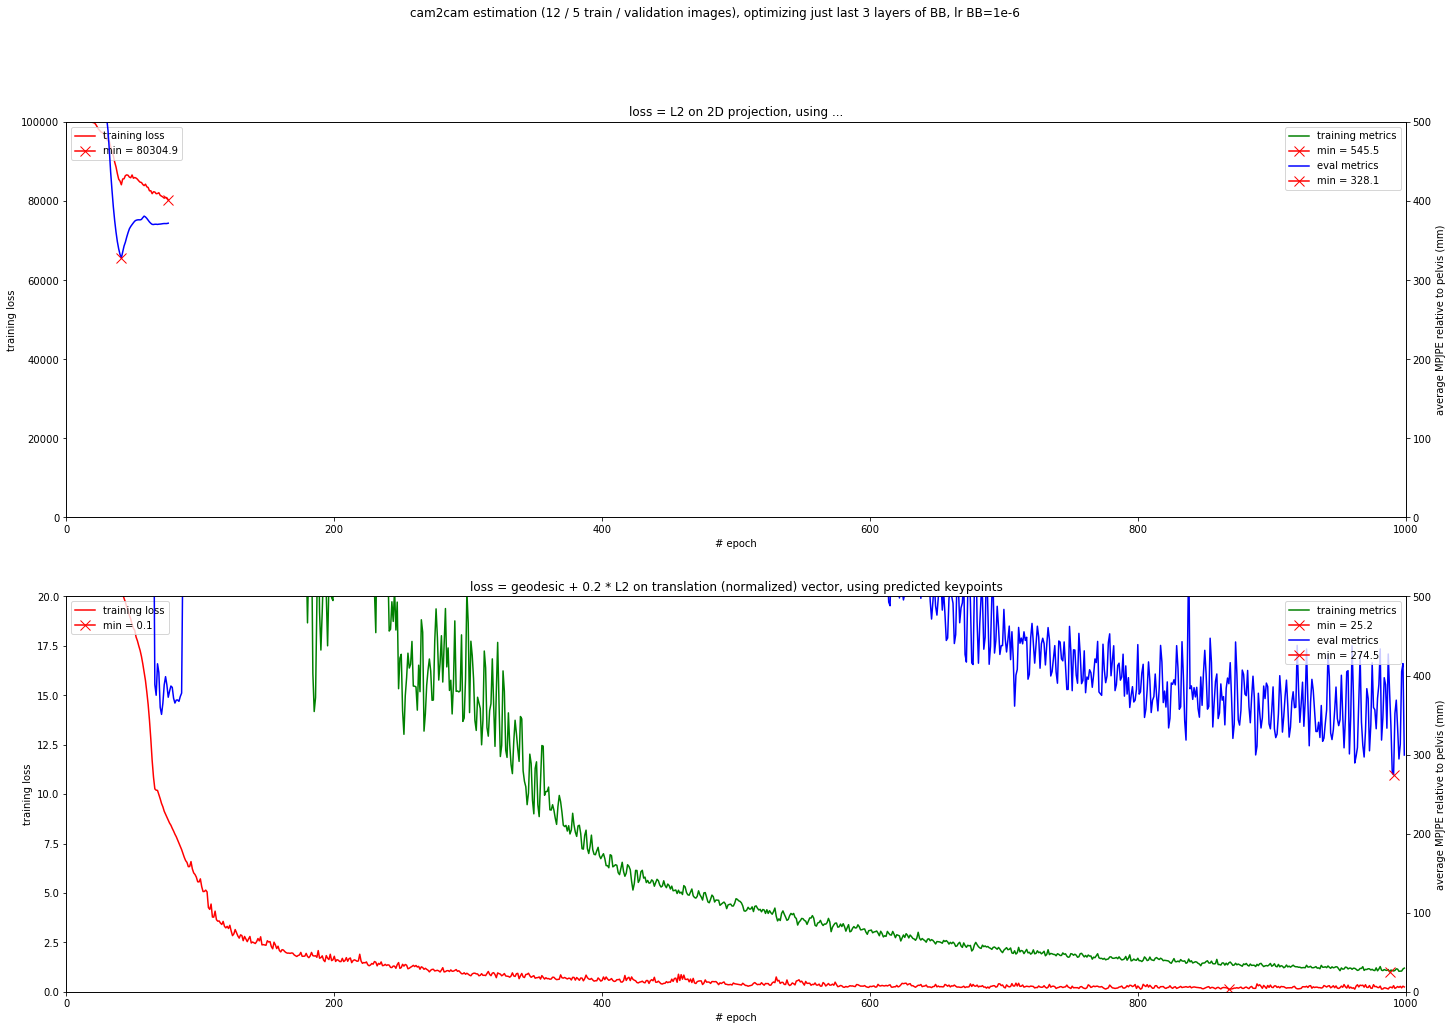

In [183]:
fig, axis = get_figa(2, 1, heigth=8, width=24)
metrics_ylim = [0, 500]
max_epochs = 1000

exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '15025136.out')
ax = axis.ravel()[0]
plot_epochs(
    ax, epochs,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    loss_ylim=[0, 1e5],
    title='loss = L2 on 2D projection, using ...',
    metric_ylabel='average MPJPE relative to pelvis (mm)'
)
ax.set_xlim([0, max_epochs])

exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '14794130.out')
ax = axis.ravel()[1]
plot_epochs(
    ax, epochs,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    loss_ylim=[0, 20],
    title='loss = geodesic + 0.2 * L2 on translation (normalized) vector, using predicted keypoints',
    metric_ylabel='average MPJPE relative to pelvis (mm)'
)
ax.set_xlim([0, max_epochs])

fig.suptitle('cam2cam estimation (12 / 5 train / validation images), optimizing just last 3 layers of BB, lr BB=1e-6')
# cam2cam_proj_VS_geo_loss.png

human36m_alg_AlgebraicTriangulationNet@05.05.2021-09:18:03 (from /home/stefano/Scuola/now/thesis/milestones/29.04_06.05_scaling-up/15025136.out)
training on 12, evaluating on 5
found 397 epochs
training loss in [69461.0, 111054.8]
training metrics in [545.5, 68789.2]
eval metrics in [328.1, 872.3]
- plotted metrics [69461.0, 111054.8] in epochs [0, 396]
- plotted metrics [545.5, 68789.2] in epochs [0, 396]
- plotted metrics [328.1, 872.3] in epochs [0, 396]
human36m_alg_AlgebraicTriangulationNet@05.05.2021-09:28:06 (from /home/stefano/Scuola/now/thesis/milestones/29.04_06.05_scaling-up/15025165.out)
training on 12, evaluating on 5
found 448 epochs
training loss in [23681.7, 80541.1]
training metrics in [256.7, 760.8]
eval metrics in [250.9, 438.0]
- plotted metrics [23681.7, 80541.1] in epochs [0, 447]
- plotted metrics [256.7, 760.8] in epochs [0, 447]
- plotted metrics [250.9, 438.0] in epochs [0, 447]
human36m_alg_AlgebraicTriangulationNet@05.05.2021-09:48:20 (from /home/stefano/Scu

Text(0.5, 0.98, 'cam2cam estimation (12 / 5 train / validation images), optimizing just last 3 layers of BB, lr BB=1e-6, using predicted KP')

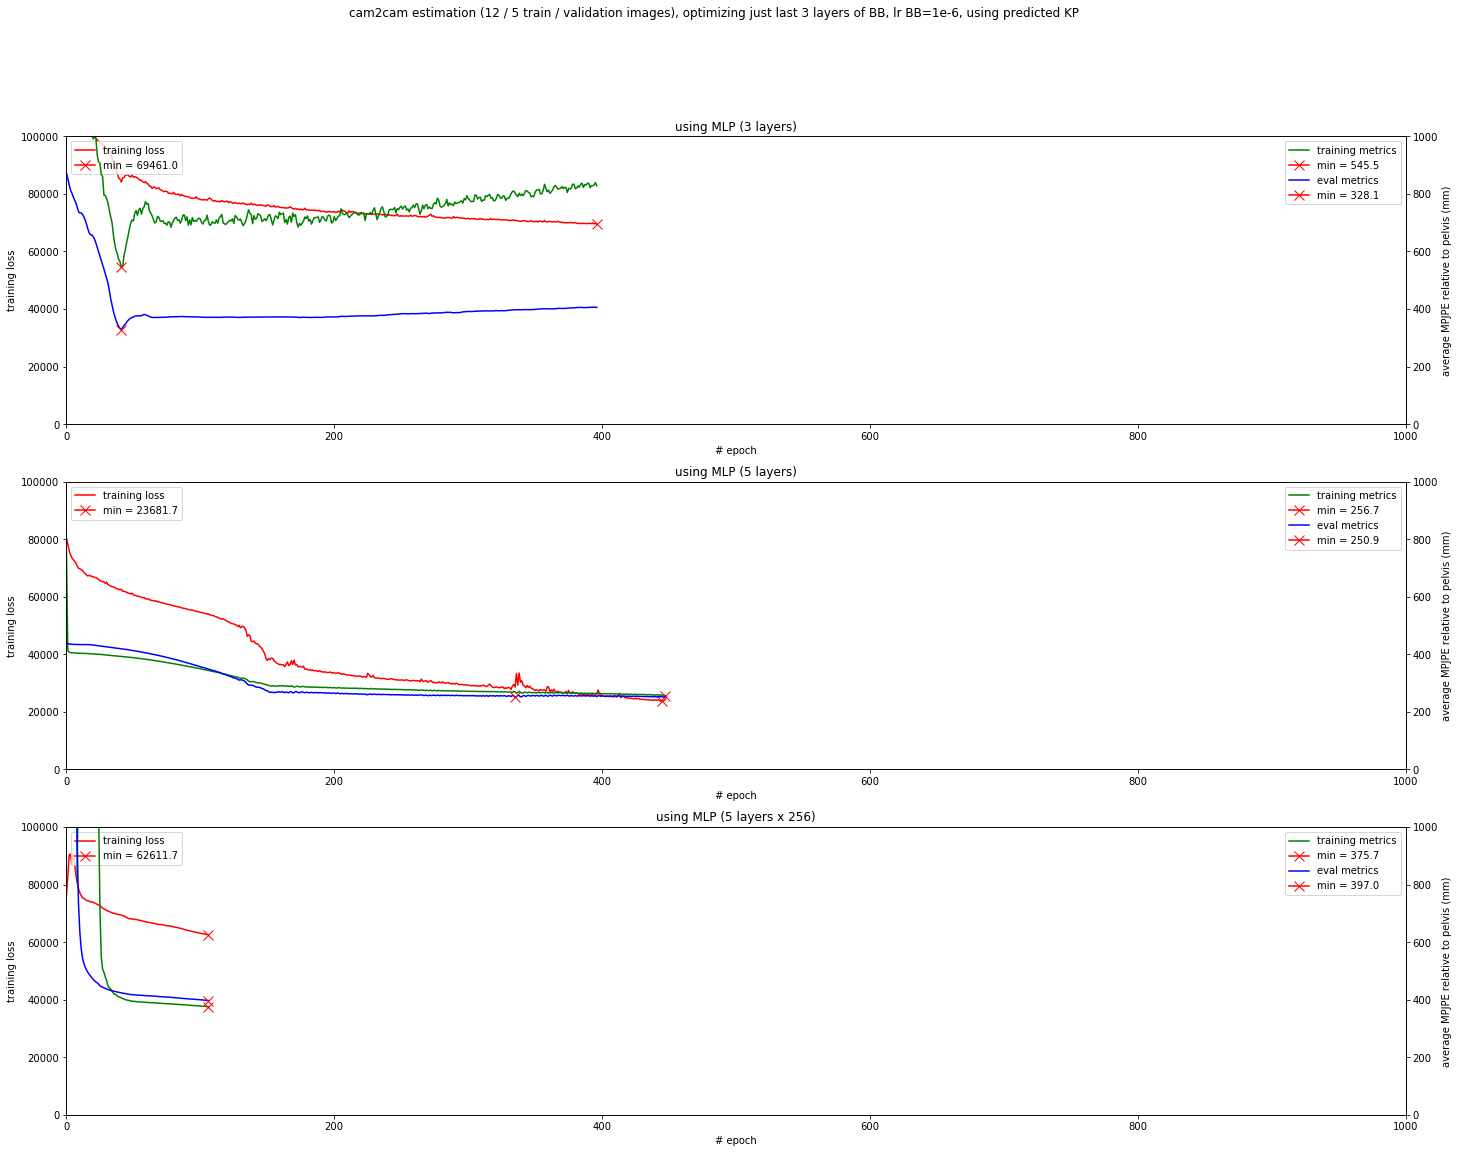

In [195]:
fig, axis = get_figa(3, 1, heigth=6, width=24)
metrics_ylim = [0, 1000]
max_epochs = 1000

exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '15025136.out')
ax = axis.ravel()[0]
plot_epochs(
    ax, epochs,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    loss_ylim=[0, 1e5],
    title='using MLP (3 layers)',
    metric_ylabel='average MPJPE relative to pelvis (mm)'
)
ax.set_xlim([0, max_epochs])

exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '15025165.out')
ax = axis.ravel()[1]
plot_epochs(
    ax, epochs,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    loss_ylim=[0, 1e5],
    title='using MLP (5 layers)',
    metric_ylabel='average MPJPE relative to pelvis (mm)'
)
ax.set_xlim([0, max_epochs])

exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '15025792.out')
ax = axis.ravel()[2]
plot_epochs(
    ax, epochs,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    loss_ylim=[0, 1e5],
    title='using MLP (5 layers x 256)',
    metric_ylabel='average MPJPE relative to pelvis (mm)'
)
ax.set_xlim([0, max_epochs])

fig.suptitle('cam2cam estimation (12 / 5 train / validation images), optimizing just last 3 layers of BB, lr BB=1e-6, using predicted KP')
# cam2cam_proj_VS_geo_loss.png